# Spectral Analysis 

In [2]:
import numpy as np
import pandas as pd
import h5py
import dask.array as da
import dask.dataframe as dd
import dask
import matplotlib.pyplot as plt

file = '../../data/pair3.mat'

f = h5py.File(file, 'r')

trace = f['s_traces']
trace_T = trace[:].T
s_traces = da.from_array(trace_T, chunks=(10000, 10000))

s_traces_real = s_traces['real']  
s_traces_imag = s_traces['imag']
df_real = dd.from_dask_array(s_traces_real, columns=[i for i in range(s_traces_real.shape[1])])
df_i = dd.from_dask_array(s_traces_imag, columns= [i for i in range(s_traces_imag.shape[1])])

print(df_real.head())

       0         1         2         3         4         5         6     \
0  0.000266  0.000339  0.000397  0.000432  0.000439  0.000414  0.000355   
1 -0.000195 -0.000104 -0.000008  0.000088  0.000182  0.000268  0.000341   
2  0.000330  0.000295  0.000229  0.000140  0.000036 -0.000075 -0.000181   
3  0.000382  0.000312  0.000213  0.000092 -0.000038 -0.000163 -0.000269   
4  0.000020  0.000073  0.000113  0.000137  0.000142  0.000130  0.000104   

       7         8         9     ...  5990  5991  5992  5993  5994  5995  \
0  0.000264  0.000147  0.000013  ...   0.0   0.0   0.0   0.0   0.0   0.0   
1  0.000397  0.000430  0.000436  ...   0.0   0.0   0.0   0.0   0.0   0.0   
2 -0.000274 -0.000345 -0.000389  ...   0.0   0.0   0.0   0.0   0.0   0.0   
3 -0.000344 -0.000378 -0.000367  ...   0.0   0.0   0.0   0.0   0.0   0.0   
4  0.000065  0.000019 -0.000030  ...   0.0   0.0   0.0   0.0   0.0   0.0   

   5996  5997  5998  5999  
0   0.0   0.0   0.0   0.0  
1   0.0   0.0   0.0   0.0  
2   0.0 

## 2. Datetime processing

In [3]:
from datetime import timedelta, datetime

with h5py.File(file, "r") as mat_file:
    s_dates = mat_file["s_dates"][:]  
s_dates = s_dates.flatten()

def datenum_to_datetime(datenum):
    """
    Convert Matlab datenum into Python datetime.
    :param datenum: Date in datenum format
    :return:        Datetime object corresponding to datenum.
    """
    days = datenum % 1
    python_date = datetime.fromordinal(int(datenum)) \
           + timedelta(days=days) \
           - timedelta(days=366)
    
    if python_date.second > 30:
        python_date = python_date + timedelta(minutes=1)  
        python_date = python_date.replace(second=0)  

    return python_date.strftime("%Y-%m-%d-%H-%M")

s_dates_to_python = np.array([datenum_to_datetime(d) for d in s_dates])
s_dates_df = pd.DataFrame(s_dates_to_python, columns= ['date'])

s_dates_df

,date
0,2012-01-04-09-28
1,2012-01-04-09-49
2,2012-01-04-10-27
3,2012-01-04-11-05
4,2012-01-04-11-13
...,...
76675,2021-06-08-10-06
76676,2021-06-08-10-08
76677,2021-06-08-10-10
76678,2021-06-08-10-11


## 3. Spectral analysis method using Machine learning

### Adding label to the data

In [4]:
def get_index(time, date_df):
    return date_df[date_df['date'].isin(time)].index.to_numpy()

defect_pos = int(get_index(['2021-06-08-09-15'], s_dates_df))
defect_pos

C:\Users\Ha Tung Lam\AppData\Local\Temp\ipykernel_55904\2192542057.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  defect_pos = int(get_index(['2021-06-08-09-15'], s_dates_df))


76650

In [5]:
def add_label(df, defect_id):
    
    m = len(df)
    y = np.zeros(m)
    y[defect_id:] = 1
    yint = y.astype(int)

    return yint

label = add_label(df_real, defect_pos)

In [6]:
label

array([0, 0, 0, ..., 1, 1, 1])

### Transforming signal data from Time Domain to Frequency Domain

In [7]:
from scipy.fft import rfft, rfftfreq

def fourier(signal, sampling_rate=1.0):
    fft_features = np.abs(rfft(signal, axis=1))
    freqs = rfftfreq(signal.shape[1], d= 1./sampling_rate)
    return fft_features, freqs

In [8]:
X_time = df_real.values.compute()  
X_freq, freqs = fourier(X_time, sampling_rate=1.0)

### Sampling Data

In [9]:
def get_index(date_df, time_list):
    index = date_df[date_df['date'].isin(time_list)].index.to_list()
    return index

In [10]:
time_1 = ['2021-06-08-09-05',
          '2021-06-08-09-03',
          '2021-06-08-09-02',
          '2021-06-08-09-00']
time_2 = ['2021-06-08-09-15',
          '2021-06-08-09-16',
          '2021-06-08-09-18',
          '2021-06-08-09-19',
          '2021-06-08-09-21']
time_3 = ['2021-06-08-09-24',
          '2021-06-08-09-25',
          '2021-06-08-09-27',
          '2021-06-08-09-28',
          '2021-06-08-09-30']
time_4 = ['2021-06-08-09-52',
          '2021-06-08-09-54',
          '2021-06-08-09-55',
          '2021-06-08-09-57',
          '2021-06-08-09-59']
time_5 = [
    '2021-06-08-09-34',
    '2021-06-08-09-36',
    '2021-06-08-09-37',
    '2021-06-08-09-39',
    '2021-06-08-09-40'
]
time_6 = [
    '2021-06-08-09-43',
    '2021-06-08-09-45',
    '2021-06-08-09-46',
    '2021-06-08-09-48',
    '2021-06-08-09-50'
]
time_7 = [
    '2021-06-08-10-06',
    '2021-06-08-10-08',
    '2021-06-08-10-10',
    '2021-06-08-10-11',
    '2021-06-08-10-13'
]

In [11]:
time_1_id = get_index(s_dates_df, time_1)
time_2_id = get_index(s_dates_df, time_2)
time_3_id = get_index(s_dates_df, time_3)
time_4_id = get_index(s_dates_df, time_4)
time_5_id = get_index(s_dates_df, time_5)
time_6_id = get_index(s_dates_df, time_6)
time_7_id = get_index(s_dates_df, time_7)

In [12]:
time_1_label = 'undamaged'
time_2_label = 'part depth (2/3?) 3.5mm'
time_3_label = '3.5mm through hole'
time_4_label = '7mm through hole'
time_5_label = 'part depth 7mm around 0.6m, 0.4m'
time_6_label = 'through hole 7mm around 0.6m, 0.4m'
time_7_label = '6.5mm through hole in weld'

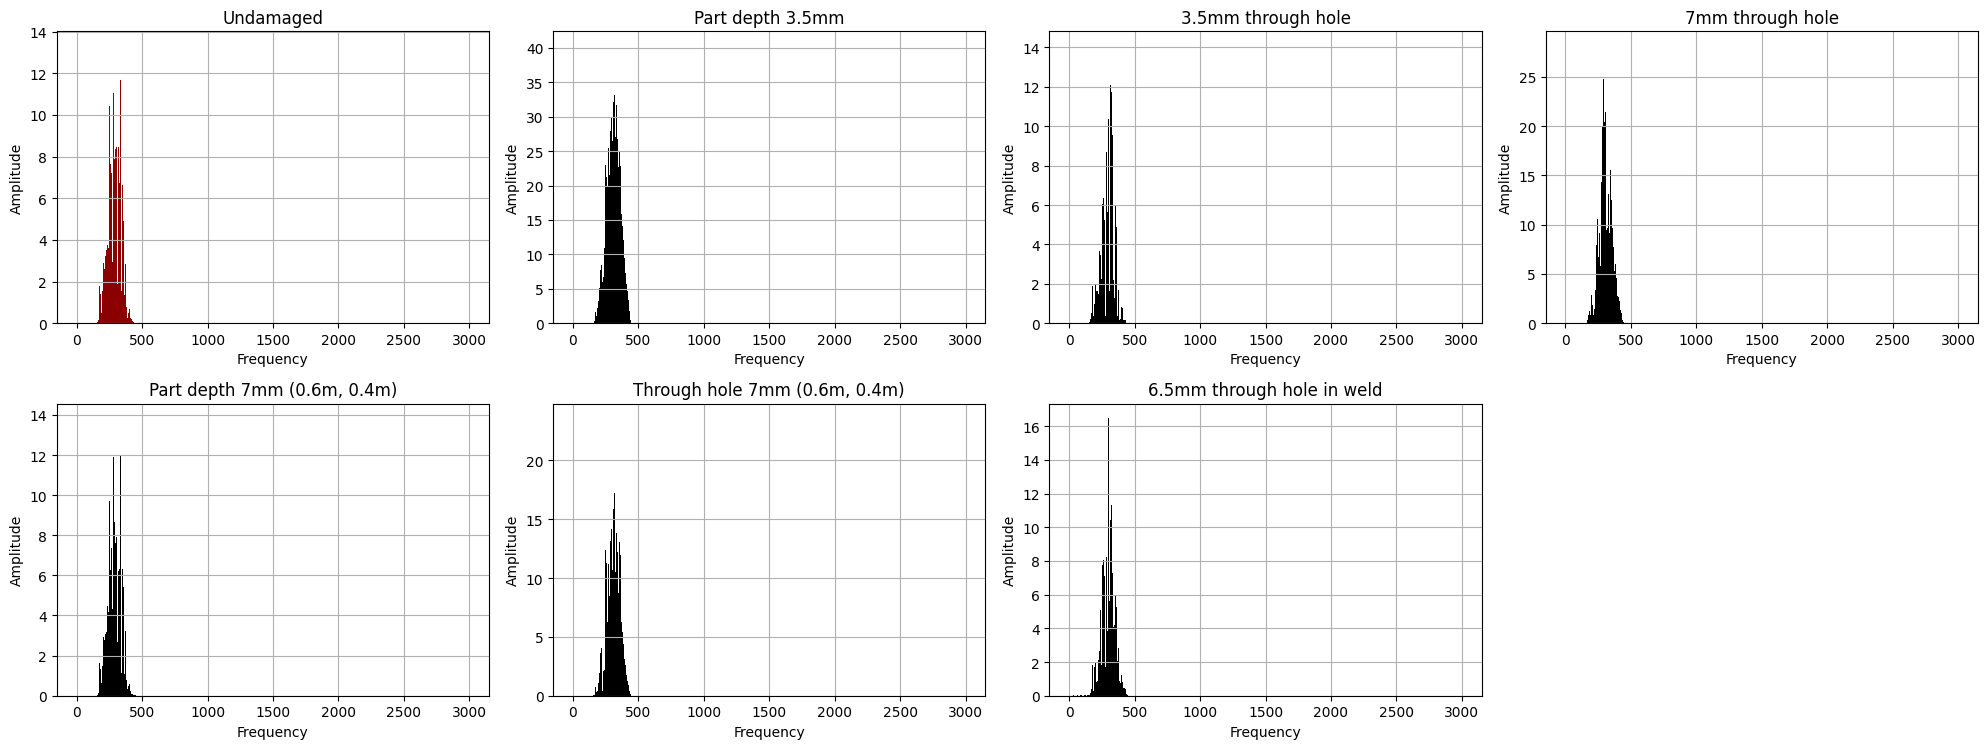

                     Defect Type  Mean Amplitude   Variance  Max Amplitude
0                      Undamaged        0.299397   1.829277      13.376265
1               Part depth 3.5mm        1.334966  27.562837      40.401338
2             3.5mm through hole        0.306413   1.895594      14.149841
3               7mm through hole        0.753560  10.292387      28.235318
4    Part depth 7mm (0.6m, 0.4m)        0.301079   1.846712      13.896287
5  Through hole 7mm (0.6m, 0.4m)        0.580971   6.213011      23.647424
6     6.5mm through hole in weld        0.336308   2.265248      16.532792


In [13]:
time_ids = [time_1_id, time_2_id, time_3_id, time_4_id, time_5_id, time_6_id, time_7_id]
time_labels = [
    'Undamaged',
    'Part depth 3.5mm',
    '3.5mm through hole',
    '7mm through hole',
    'Part depth 7mm (0.6m, 0.4m)',
    'Through hole 7mm (0.6m, 0.4m)',
    '6.5mm through hole in weld'
]

# Define colors
pristine_color = '#8B0000'   # Dark red for 'Undamaged'
defect_color = 'black'       # Black for defects

# Set up 2x4 grid for 7 plots
fig, axes = plt.subplots(2, 4, figsize=(20, 8))
axes = axes.flatten()

stats_list = []

for i, (ids, label_name) in enumerate(zip(time_ids, time_labels)):
    signals = X_freq[ids]
    mean_fft = np.mean(signals, axis=0)
    
    color = pristine_color if 'Undamaged' in label_name else defect_color

    axes[i].bar(np.arange(len(mean_fft)), mean_fft, color=color, width=1.0)
    axes[i].set_title(label_name)
    axes[i].set_xlabel('Frequency')
    axes[i].set_ylabel('Amplitude')
    axes[i].grid(True)
    
    mean_amp = np.mean(signals)
    variance = np.var(signals)
    max_amp = np.max(signals)
    
    stats_list.append([label_name, mean_amp, variance, max_amp])

# Hide the last unused subplot
axes[7].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Create DataFrame
df_stats = pd.DataFrame(stats_list, columns=['Defect Type', 'Mean Amplitude', 'Variance', 'Max Amplitude'])

# Display DataFrame
print(df_stats)

In [14]:
df_stats

,Defect Type,Mean Amplitude,Variance,Max Amplitude
0,Undamaged,0.299397,1.829277,13.376265
1,Part depth 3.5mm,1.334966,27.562837,40.401338
2,3.5mm through hole,0.306413,1.895594,14.149841
3,7mm through hole,0.753560,10.292387,28.235318
4,"Part depth 7mm (0.6m, 0.4m)",0.301079,1.846712,13.896287
5,"Through hole 7mm (0.6m, 0.4m)",0.580971,6.213011,23.647424
6,6.5mm through hole in weld,0.336308,2.265248,16.532792


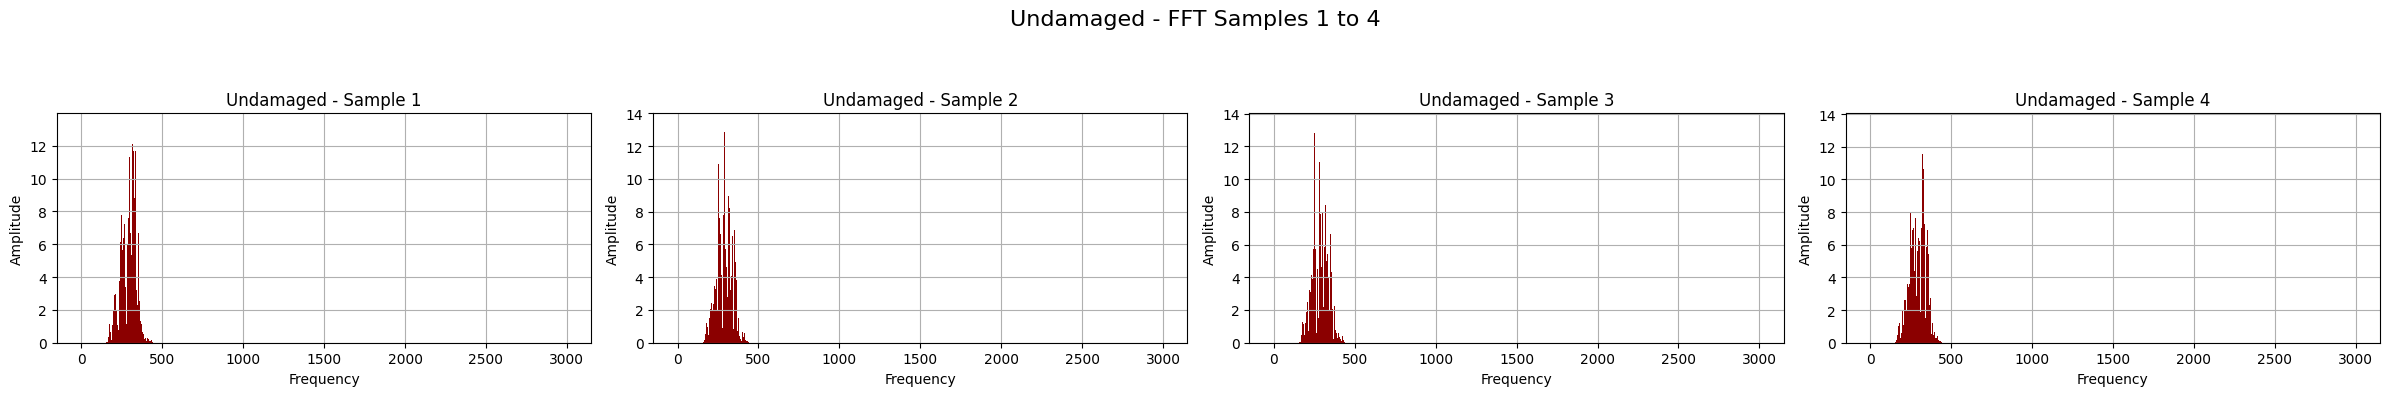

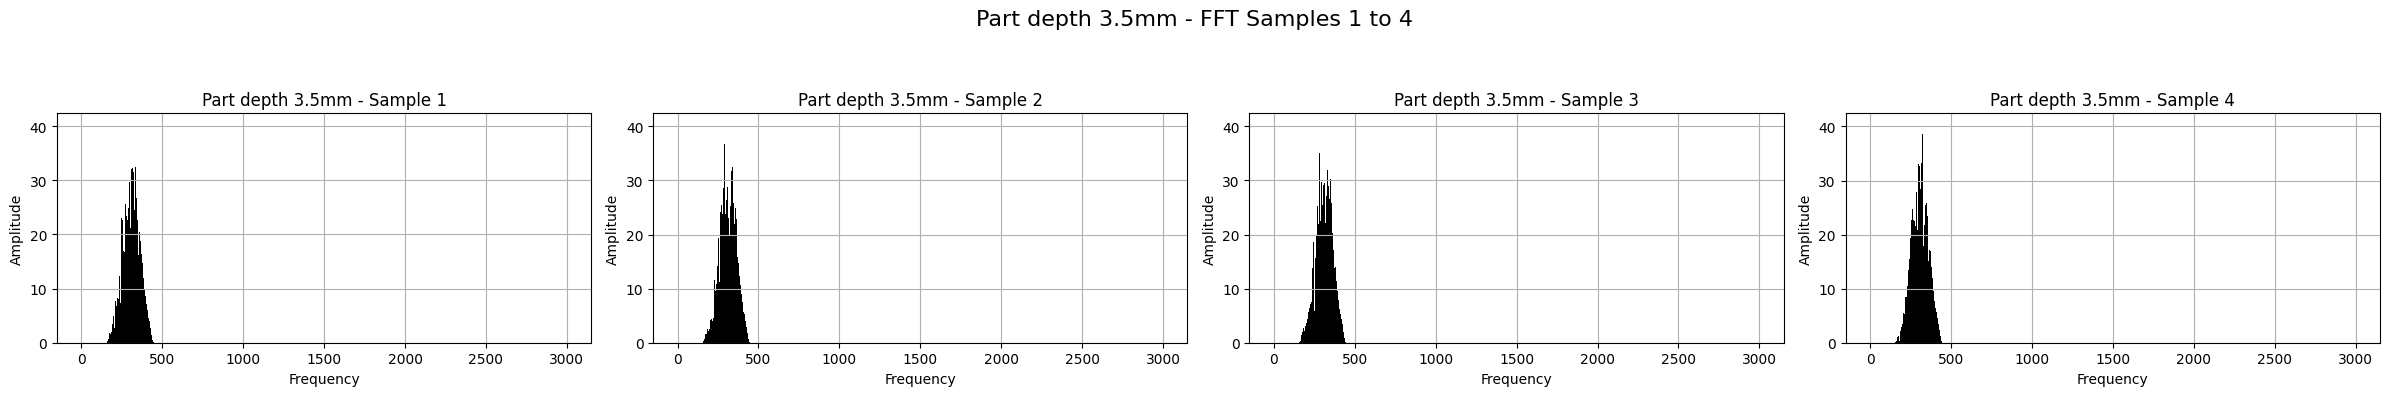

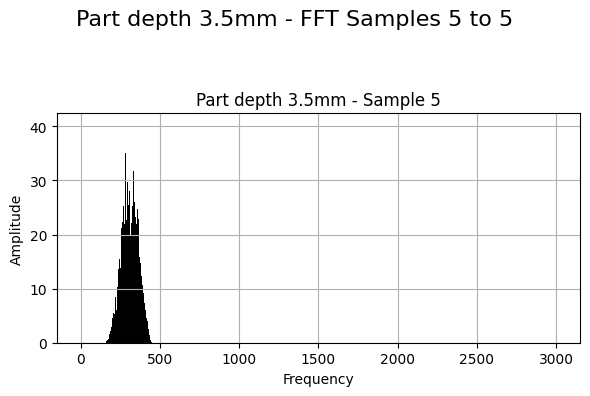

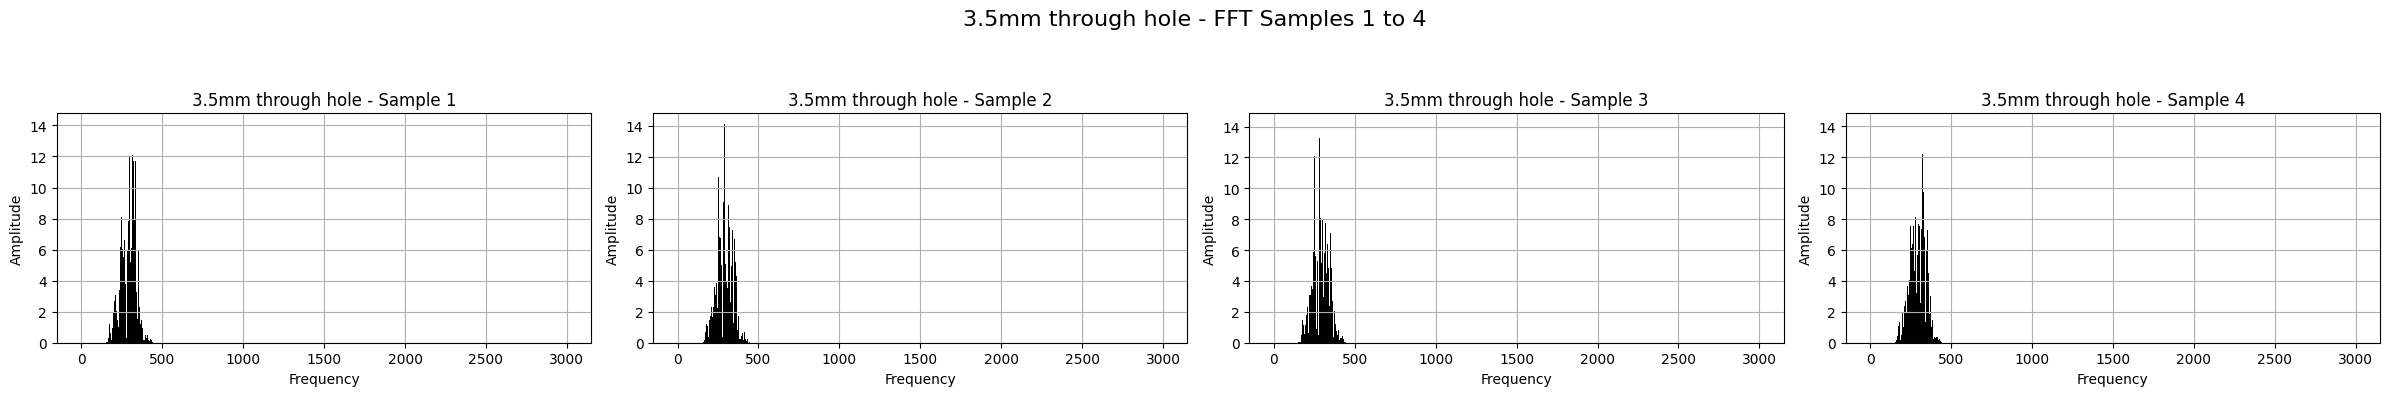

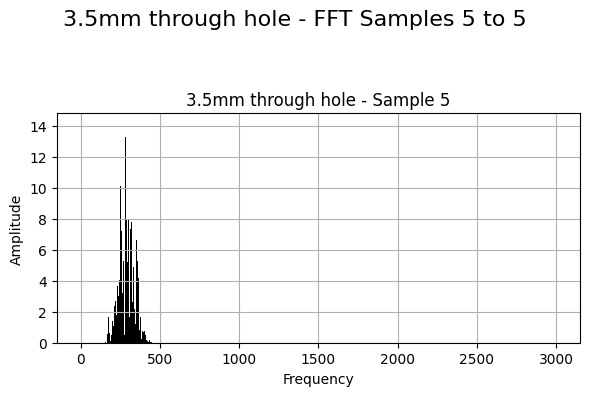

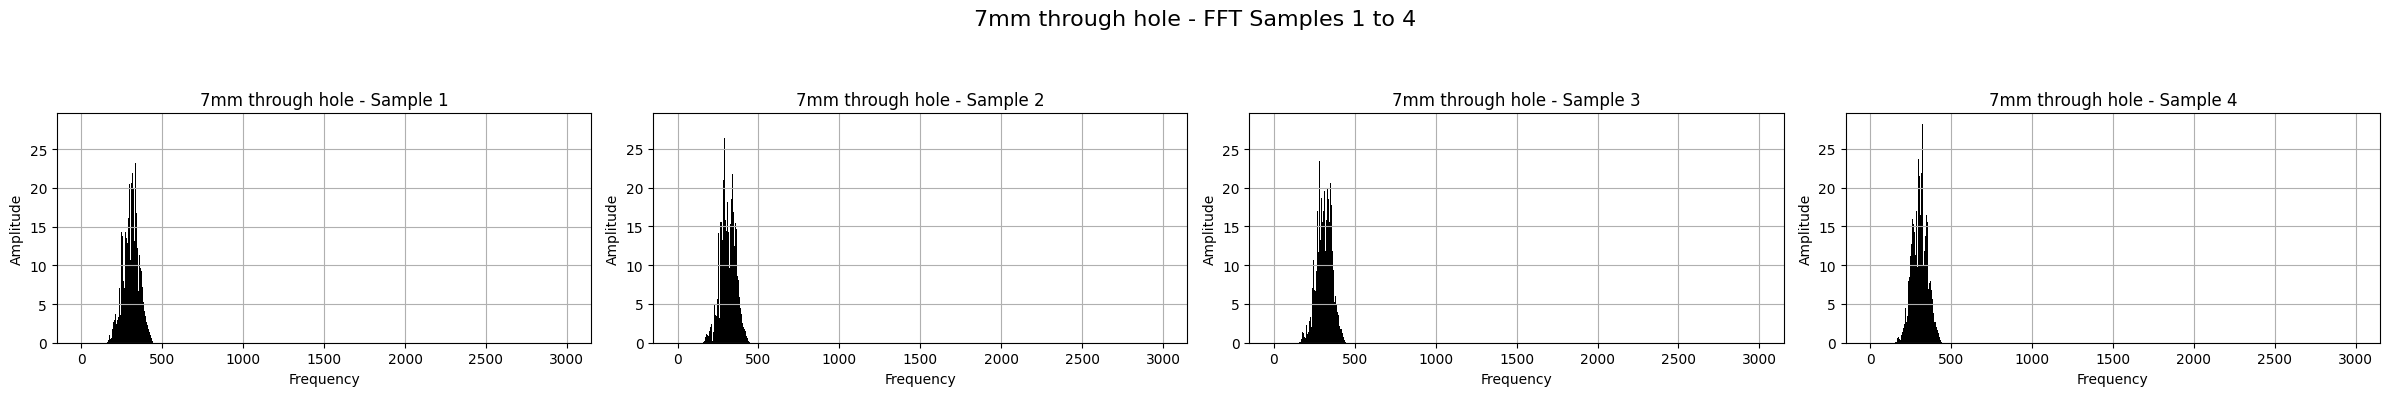

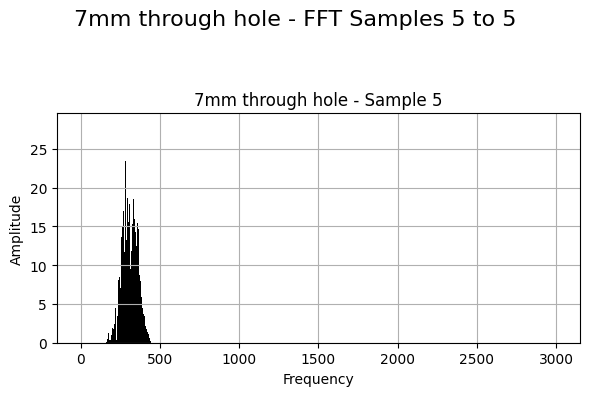

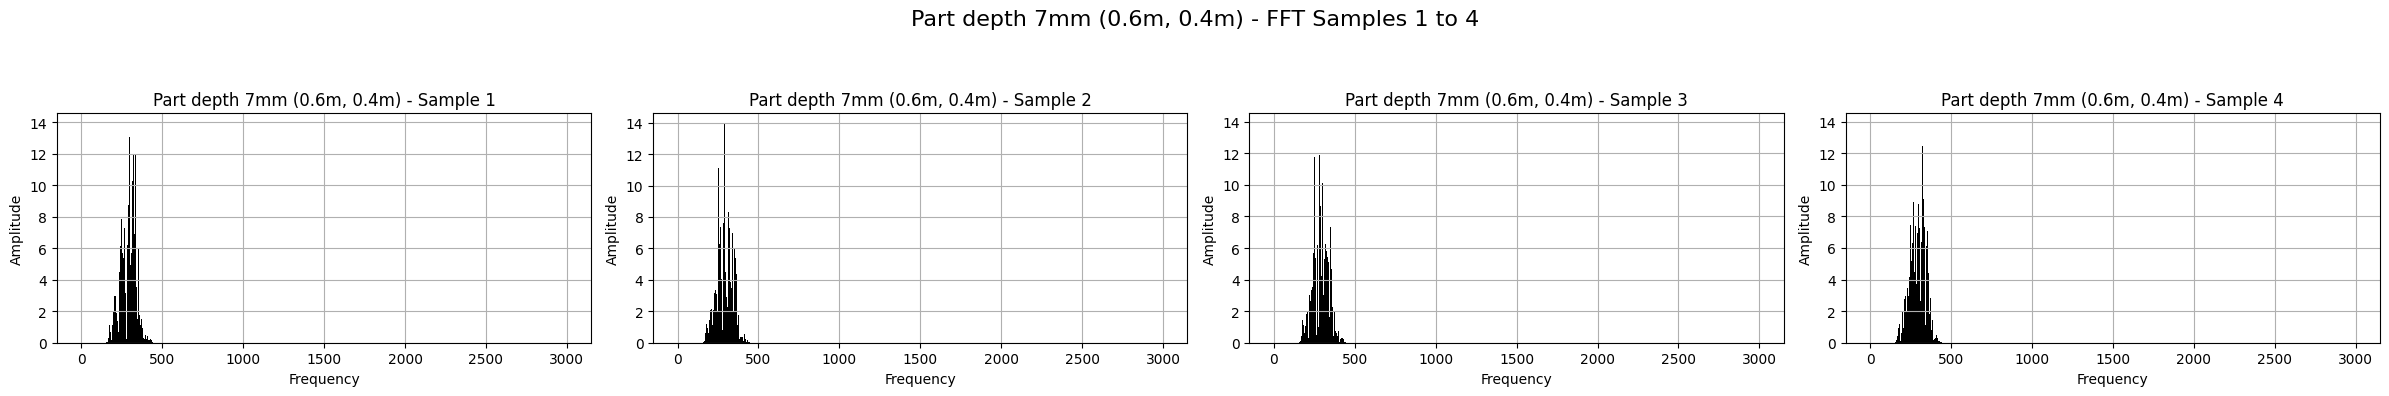

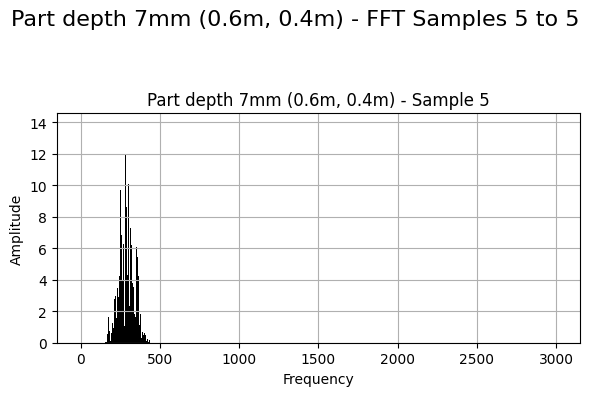

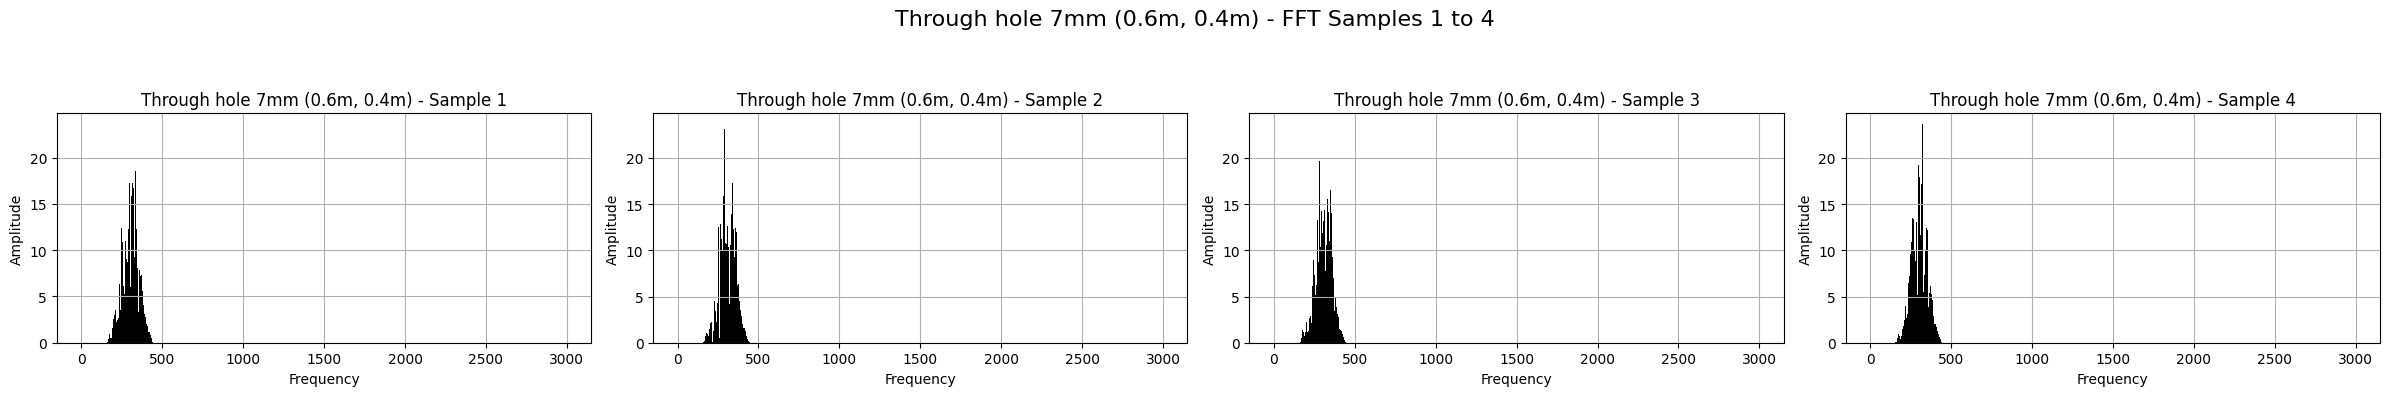

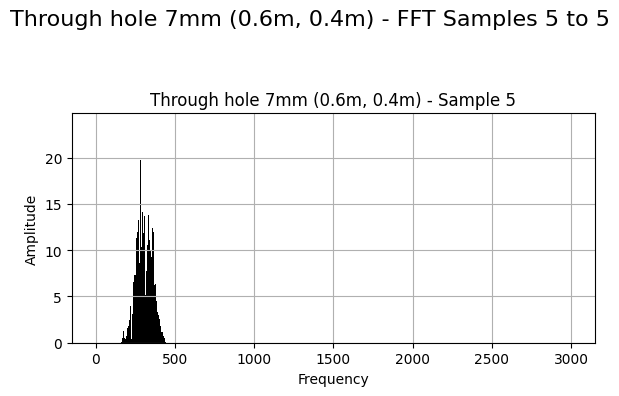

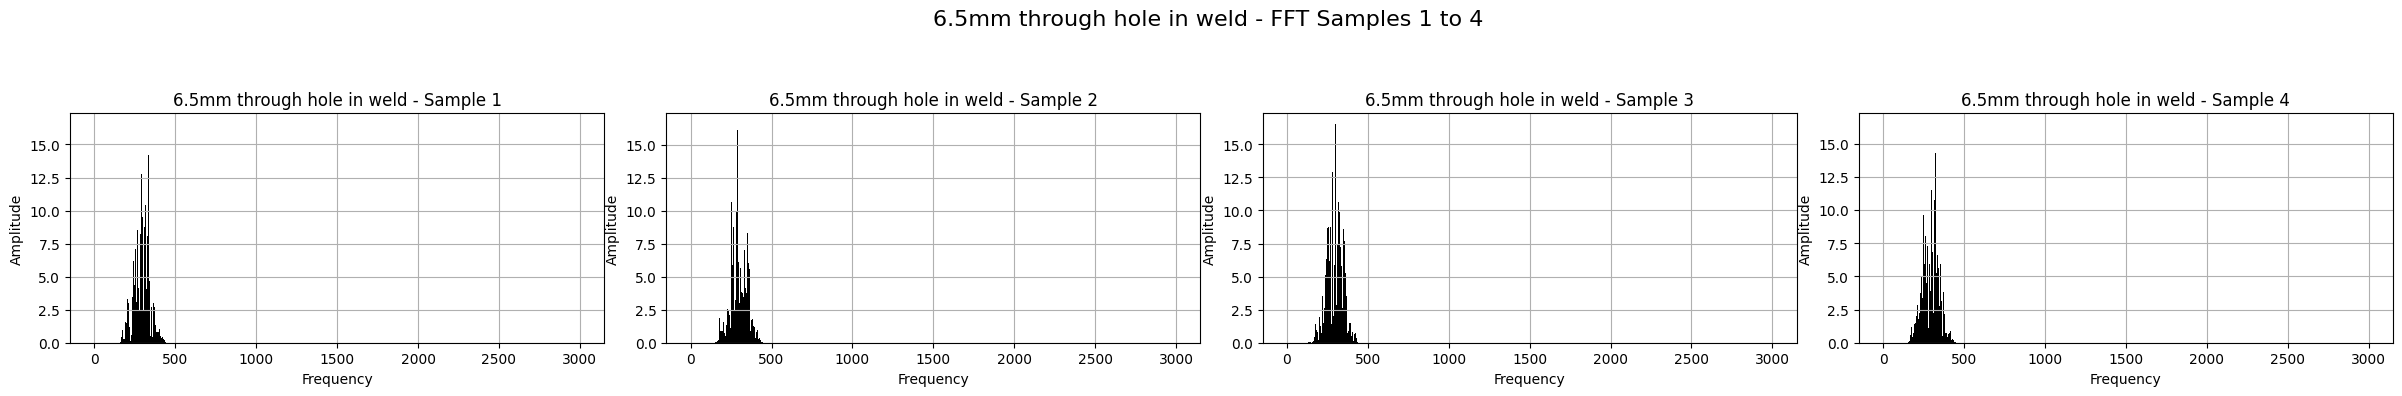

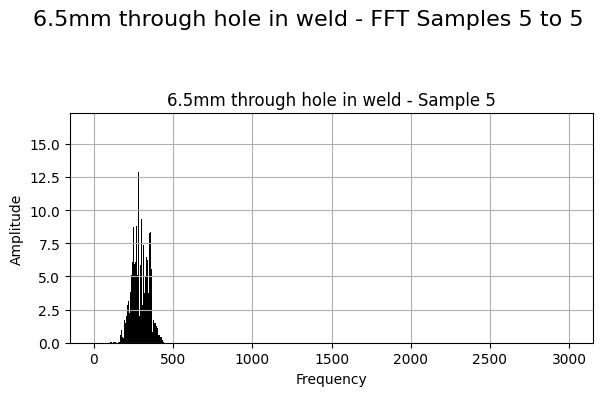

In [15]:
def plot_individual_fft(time_ids, time_labels, X_freq):
    pristine_color = '#8B0000'
    defect_color = 'black'
    
    for ids, label_name in zip(time_ids, time_labels):
        signals = X_freq[ids]
        num_signals = signals.shape[0]
        
        # Plot in batches of 4
        batch_size = 4
        for i in range(0, num_signals, batch_size):
            batch_signals = signals[i:i+batch_size]
            fig, axes = plt.subplots(1, len(batch_signals), figsize=(6 * len(batch_signals), 4))
            
            if len(batch_signals) == 1:
                axes = [axes]  # Ensure axes is iterable if only one plot
            
            for j, signal in enumerate(batch_signals):
                color = pristine_color if 'Undamaged' in label_name else defect_color
                axes[j].bar(np.arange(len(signal)), signal, color=color, width=1.0)
                axes[j].set_title(f"{label_name} - Sample {i + j + 1}")
                axes[j].set_xlabel('Frequency')
                axes[j].set_ylabel('Amplitude')
                axes[j].grid(True)
            
            fig.suptitle(f"{label_name} - FFT Samples {i + 1} to {i + len(batch_signals)}", fontsize=16)
            plt.tight_layout(rect=[0, 0, 1, 0.90])
            plt.show()

# Call the function
plot_individual_fft(time_ids, time_labels, X_freq)

In [16]:
chosen_indices = np.concatenate([time_1_id, time_2_id, time_3_id, time_4_id, time_5_id, time_6_id, time_7_id])

# 2. Extract the subset of data and labels
X_subset = X_freq[chosen_indices]
y_subset = label[chosen_indices]

# 3. Split into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_subset, 
    y_subset, 
    test_size=0.5,         # 30% test, 70% train (you can adjust)
    random_state=42, 
    stratify=y_subset      # Keep class distribution balanced
)

# Check the shapes
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train distribution: {np.bincount(y_train)}")
print(f"y_test distribution: {np.bincount(y_test)}")

X_train shape: (17, 3001)
X_test shape: (17, 3001)
y_train distribution: [ 2 15]
y_test distribution: [ 2 15]


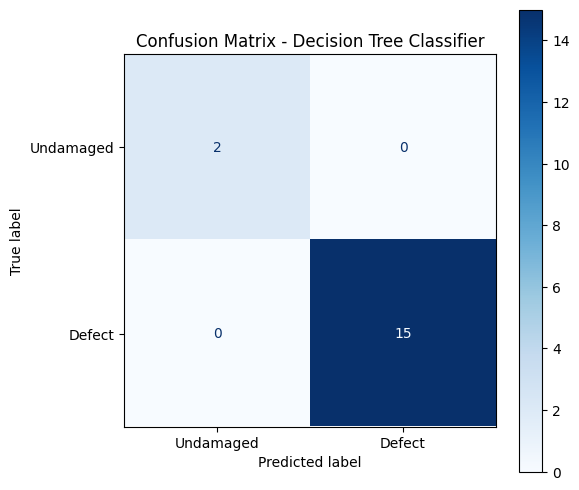

              precision    recall  f1-score   support

   Undamaged       1.00      1.00      1.00         2
      Defect       1.00      1.00      1.00        15

    accuracy                           1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17



In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Initialize Decision Tree with basic tuning
clf = DecisionTreeClassifier(max_depth=5, min_samples_split=4, random_state=42)

# 2. Train the model
clf.fit(X_train, y_train)

# 3. Predict on test set
y_pred = clf.predict(X_test)

# 4. Evaluate using confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Undamaged', 'Defect'])

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='Blues')
plt.title("Confusion Matrix - Decision Tree Classifier")
plt.show()

# 5. Print detailed classification metrics
print(classification_report(y_test, y_pred, target_names=['Undamaged', 'Defect']))

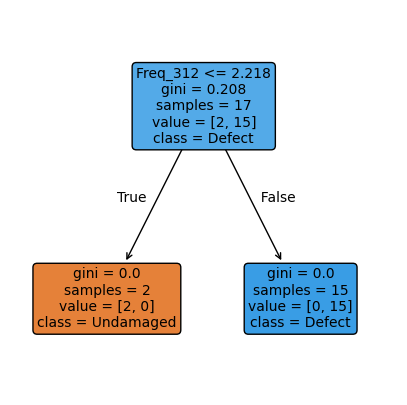

In [18]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5)) 

plot_tree(clf, 
          filled=True, 
          feature_names=[f'Freq_{i}' for i in range(X_train.shape[1])], 
          class_names=['Undamaged', 'Defect'], 
          rounded=True, 
          fontsize=10)   

plt.show()

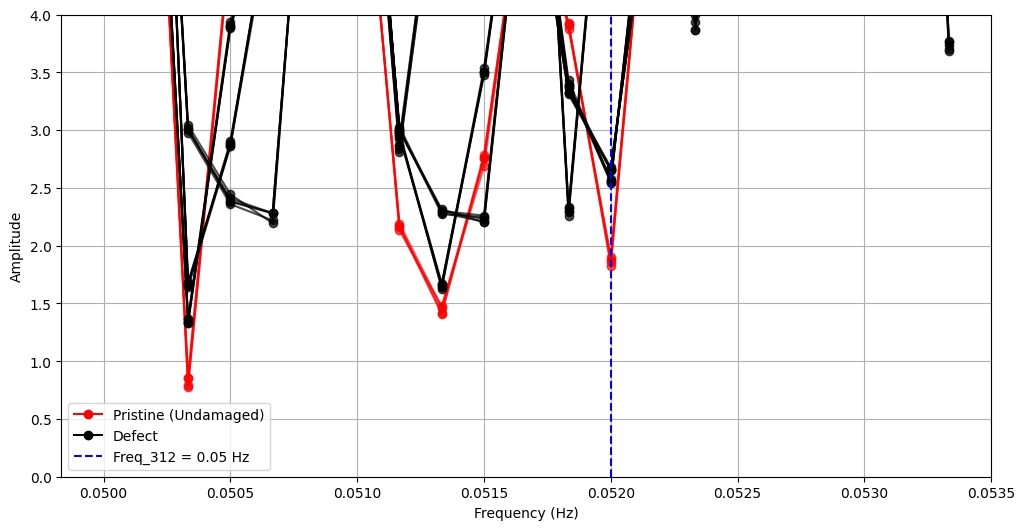

In [19]:
import matplotlib.lines as mlines

chosen_indices = np.concatenate([time_1_id, time_2_id, time_3_id, time_4_id, time_5_id, time_6_id, time_7_id])
X_subset = X_freq[chosen_indices]
y_subset = label[chosen_indices]

# Select frequency range: bins 300 to 320
start_bin = 300
end_bin = 320

freq_range = freqs[start_bin:end_bin+1]
X_zoom = X_subset[:, start_bin:end_bin+1]

# Plot all lines
plt.figure(figsize=(12, 6))

for i in range(len(X_zoom)):
    color = 'red' if y_subset[i] == 0 else 'black'
    plt.plot(freq_range, X_zoom[i], color=color, alpha=0.7, marker='o')

# Mark Freq_312 with a vertical dashed line
plt.axvline(x=freqs[312], color='blue', linestyle='--')

# Create custom legend handles
pristine_line = mlines.Line2D([], [], color='red', marker='o', linestyle='-', label='Pristine (Undamaged)')
defect_line = mlines.Line2D([], [], color='black', marker='o', linestyle='-', label='Defect')
threshold_line = mlines.Line2D([], [], color='blue', linestyle='--', label=f'Freq_312 = {freqs[312]:.2f} Hz')

# Add legend
plt.legend(handles=[pristine_line, defect_line, threshold_line])

# Labels and grid
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.ylim(0, 4)
plt.grid(True)
plt.show()

Advance testing

In [20]:
label_test = np.zeros(len(chosen_indices), dtype=int)

time_groups = [time_1_id, time_2_id, time_3_id, time_4_id, time_5_id, time_6_id, time_7_id]

counter = 0
for idx, group in enumerate(time_groups):
    label_test[counter: counter + len(group)] = idx
    counter += len(group)

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_subset, label_test, test_size=0.5, random_state=42, stratify=label_test
)

In [22]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=42, max_depth=4)  # Limiting depth for clearer visualization
clf.fit(X_train, y_train)   

DecisionTreeClassifier(max_depth=4, random_state=42)

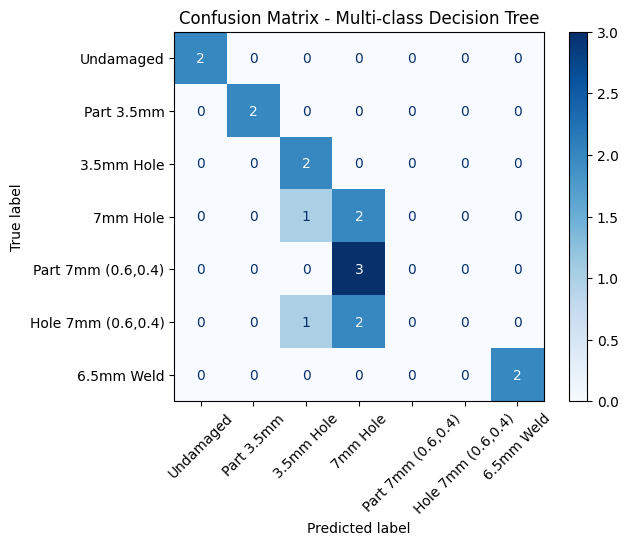

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[
    'Undamaged', 'Part 3.5mm', '3.5mm Hole', '7mm Hole', 
    'Part 7mm (0.6,0.4)', 'Hole 7mm (0.6,0.4)', '6.5mm Weld'
])
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - Multi-class Decision Tree")
plt.show()

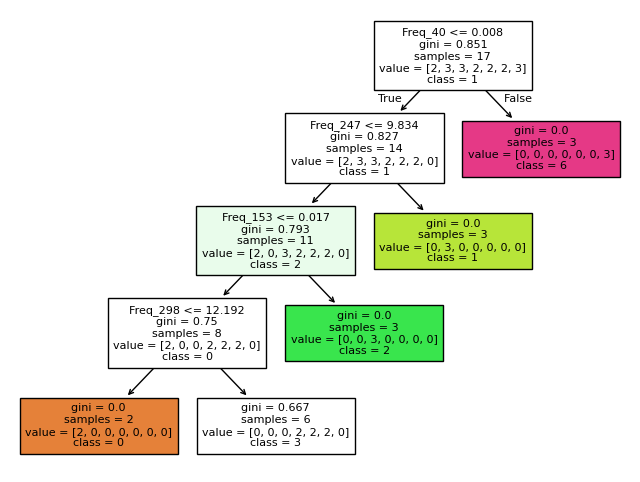

In [30]:
from sklearn.tree import plot_tree

plt.figure(figsize=(8,6))
plot_tree(clf, feature_names=[f'Freq_{i}' for i in range(X_subset.shape[1])],
          class_names=['0','1','2','3','4','5','6'], filled=True, fontsize=8)
plt.show()